# Inference

Exploratory data analysis on the effect of inference.

In [1]:
using PyPlot, Printf

include("../decode.jl")
include("../utils.jl")
include("../inference.jl")
include("../regression.jl")

include("../UpdateRule.jl")
include("../Leaky.jl")
include("../VarSMiLe.jl")
include("../ParticleFiltering.jl")
;

In [3]:
function plot_heatmap(values, xticks, xlabels, yticks, ylabels, title, filename, xlabel)
    heatmap = imshow(values', origin="lower left", cmap="rainbow", vmin=0, vmax=1)
    ax = gca()

    # set x-axis
    ax.set_xlabel(xlabel)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

    # set y-axis
    ax.set_ylabel(L"p")
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)

    # colorbar at the end
    cbar = colorbar(heatmap)

    # add title
    PyPlot.title(title)
    display(gcf())
    
    if filename != nothing
        savefig(filename)
    end
    
    clf()
end

function plot_heatmap_w(values, xticks, xlabels, yticks, ylabels, title, filename)
    return plot_heatmap(values, xticks, xlabels, yticks, ylabels, title, filename,
        L"Timescale of integration ($\omega$)")
end

function plot_heatmap_p(values, xticks, xlabels, yticks, ylabels, title, filename)
    return plot_heatmap(values, xticks, xlabels, yticks, ylabels, title, filename,
        L"Reciprocal of change probability ($\frac{1}{p_c}$)")
end
;

In [4]:
# sequence length
L = 300

# heatmap params
resolution = 21
ps = range(0, 1, length=resolution) |> collect

# prior for models
prior = prior_uniform(4)
;

## Leaky integration

In [5]:
# heatmap params
ws = vcat(log2range(0, 10, resolution-1), Inf);

In [6]:
leaky_avgs  = zeros(length(ws), length(ps))
leaky_freqs = zeros(length(ws), length(ps))
leaky_post  = zeros(length(ws), length(ps), length(prior))

leaky_runs = 0;

In [7]:
for k in 1:20
    for (i, w) in enumerate(ws), (j, p) in enumerate(ps)
        # generate random sequence of length L, with P(x = 1) = p
        seq = rand(Bernoulli(p), L)

        # create update rule    
        rule = Leaky(w, prior, leakprior=true, updateallcols=true)

        # decode sequence
        posterior = decodeposterior(seq, rule)

        # store as result
        leaky_avgs[i,j]   += mean(posterior)[1]
        leaky_post[i,j,:] += mean(posterior)
        leaky_freqs[i,j]  += mean(map(p -> findmax(p)[1] == p[1], posterior))
        
    end
    leaky_runs += 1
    println("$k")
end
;

1234567891011121314151617181920

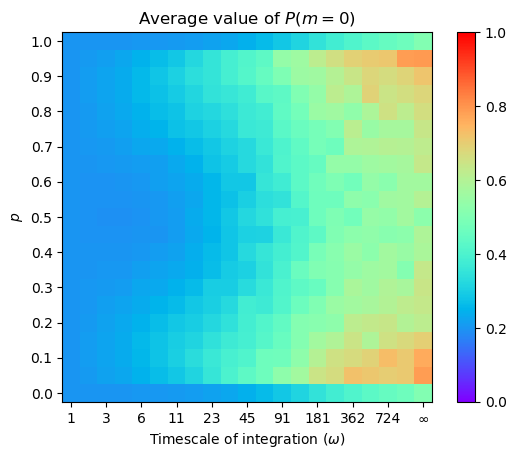

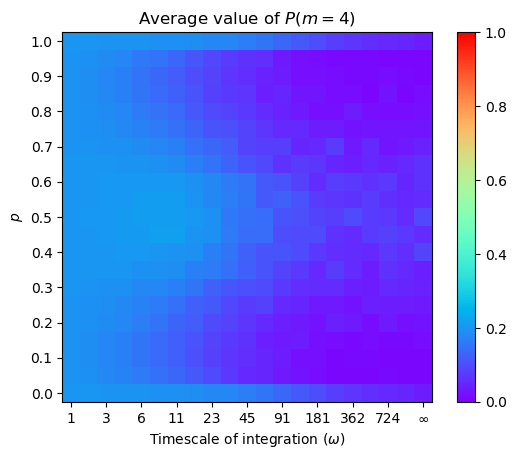

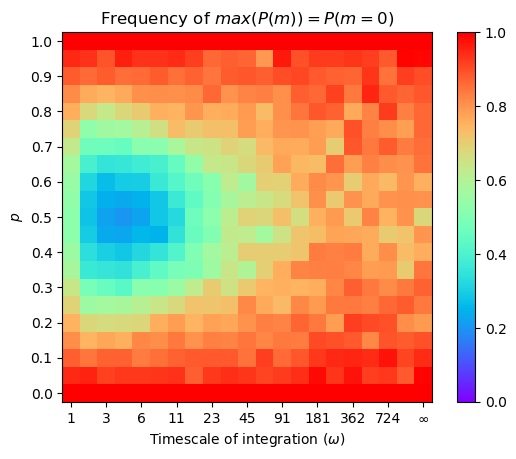

In [9]:
step = round(Int, (resolution - 1) / 10)
xticks = vcat(0:step:resolution-1)
xlabels = map(i -> ws[i+1] == Inf ? L"\infty" : @sprintf("%i", ws[i+1]), xticks)

yticks = collect(0:step:resolution-1)
ylabels = map(i -> @sprintf("%.1f", ps[i+1]), yticks)

plot_heatmap_w(leaky_avgs  / leaky_runs,  xticks, xlabels, yticks, ylabels, 
    L"Average value of $P(m = 0)$", nothing)       # "leaky_average.svg")
plot_heatmap_w(leaky_post[:,:,5]  / leaky_runs,  xticks, xlabels, yticks, ylabels, 
    L"Average value of $P(m = 4)$", nothing)       # "leaky_average.svg")
plot_heatmap_w(leaky_freqs / leaky_runs, xticks, xlabels, yticks, ylabels, 
    L"Frequency of $argmax_m(P(m)) = 0$", nothing) # "leaky_freq.svg")
;

In [7]:
leaky_avgs  = zeros(length(ws), length(ps))
leaky_freqs = zeros(length(ws), length(ps))

leaky_runs = 0;

In [7]:
for k in 1:60
    for (i, w) in enumerate(ws), (j, p) in enumerate(ps)
        # generate random sequence of length L, with P(x = 1) = p
        seq = rand(Bernoulli(p), L)

        # create update rule    
        rule = Leaky(w, prior, leakprior=true, updateallcols=true)

        # decode sequence
        posterior = decodeposterior(seq, rule)

        # store as result
        leaky_avgs[i,j]  += mean(posterior)[2]
        leaky_freqs[i,j] += mean(map(p -> p[2] > 0.5, posterior))
    end
    leaky_runs += 1
end
;

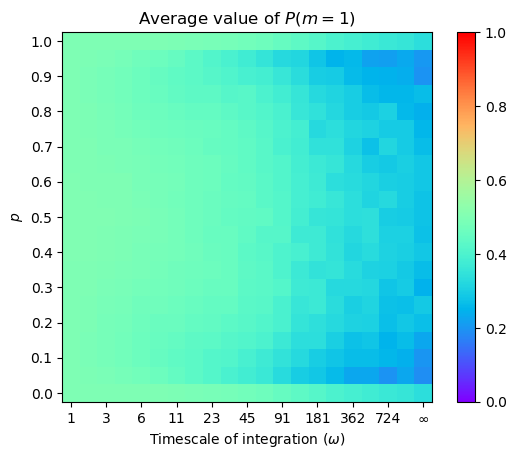

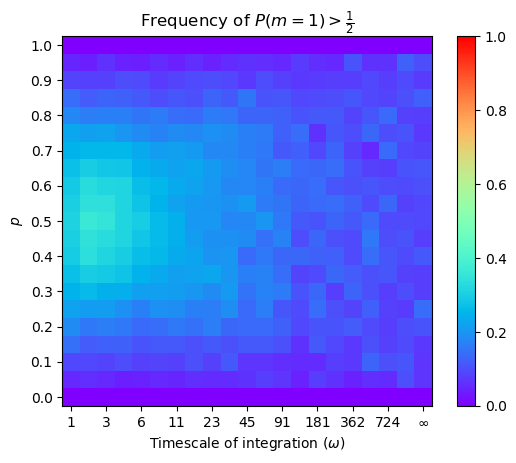

In [8]:
step = round(Int, (resolution - 1) / 10)
xticks = vcat(0:step:resolution-1)
xlabels = map(i -> ws[i+1] == Inf ? L"\infty" : @sprintf("%i", ws[i+1]), xticks)

yticks = collect(0:step:resolution-1)
ylabels = map(i -> @sprintf("%.1f", ps[i+1]), yticks)

plot_heatmap_w(leaky_avgs  / leaky_runs,  xticks, xlabels, yticks, ylabels, 
    L"Average value of $P(m = 1)$", "leaky_average.svg")
plot_heatmap_w(leaky_freqs / leaky_runs, xticks, xlabels, yticks, ylabels, 
    L"Frequency of $P(m = 1) > \frac{1}{2}$", "leaky_freq.svg")
;

## Particle Filtering

In [9]:
# heatmap params
pcs = 1 .- exp.(- 1 ./ ws)
ms = pcs ./ (1 .- pcs);

In [10]:
par_avgs  = zeros(length(ms), length(ps))
par_freqs = zeros(length(ms), length(ps))

nparticles = 100
nthrs = nparticles / 2

par_runs = 0;

In [11]:
# results
for k in 1:60
    for (i, m) in enumerate(ms), (j, p) in enumerate(ps)
        # generate random sequence of length L, with P(x = 1) = p
        seq = rand(Bernoulli(p), L)

        # create update rule    
        rule = ParticleFiltering(m, nparticles, nthrs, prior, updateallcols=true)

        # decode sequence
        posterior = decodeposterior(seq, rule)

        # store as result
        par_avgs[i,j]  += mean(posterior)[2]
        par_freqs[i,j] += mean(map(p -> p[2] > 0.5, posterior))
    end
    par_runs += 1
end
;

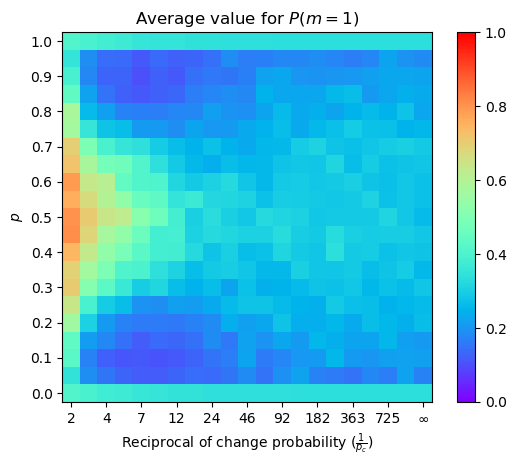

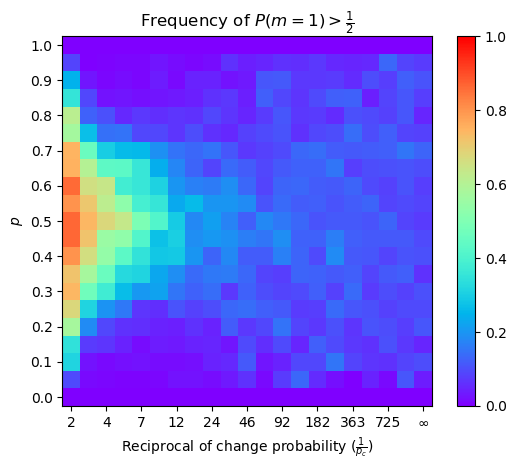

In [12]:
step = round(Int, (resolution - 1) / 10)
xticks = vcat(0:step:resolution-1)
xlabels = map(i -> ms[i+1] == 0 ? L"\infty" : @sprintf("%i", 1/ms[i+1] + 1), xticks)

yticks = collect(0:step:resolution-1)
ylabels = map(i -> @sprintf("%.1f", ps[i+1]), yticks)

plot_heatmap_p(par_avgs / par_runs,  xticks, xlabels, yticks, ylabels, 
    L"Average value for $P(m = 1)$", "particle_filtering_average.svg")
plot_heatmap_p(par_freqs / par_runs, xticks, xlabels, yticks, ylabels,
    L"Frequency of $P(m = 1) > \frac{1}{2}$", "particle_filtering_freq.svg")
;